In [2]:
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
from skimage.transform import rotate
import pims, sys
from pathlib import Path
import trackpy as tp
import pandas as pd

In [3]:
@pims.pipeline
def crop_image(frame):
    return frame[:,0:428]
   

# Location of the sample's base folder
#base_path = Path(r'C:\Users\jrosk\Dropbox\Warwick\TIRF\29-11-2022\Measurements')
base_path = Path(r'/Users/lfsmbn/orkun/projects/ongoing/GBMF_motility/Manuscript_Code/Movies')
filepath_0 = base_path.joinpath(r'21-Feb-23_TIRF473-6_LeftCh_f450_850.tif')
full_roi_stack_0 = pims.open(filepath_0.as_posix())
#images_0 = crop_image(full_roi_stack_0)
images_0=full_roi_stack_0
images_0
len(images_0)


TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


401

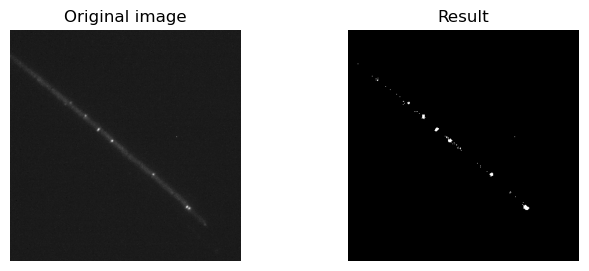

In [4]:
thresh = 550

@pims.pipeline
def thresh_image(frame):
    return frame[:,:]>thresh

images_1 = thresh_image(images_0)

fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
ax = axes.ravel()
ax[0].imshow(images_0[115], cmap=plt.cm.gray)
ax[0].set_title('Original image')
ax[1].imshow(images_1[115], cmap=plt.cm.gray)
ax[1].set_title('Result')
for a in ax:
    a.axis('off')

plt.show()

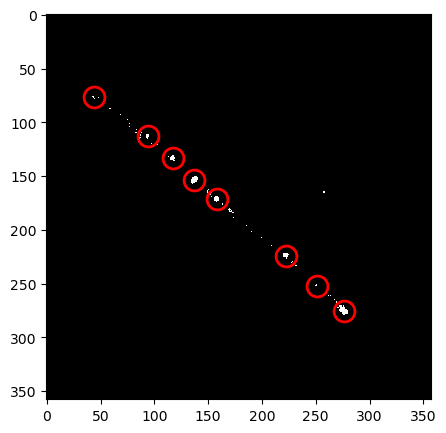

<AxesSubplot:>

In [5]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
#img_test = images_0[115] # gaussian(images_0[200])#, cutoff_frequency_ratio=0.02)
img_test = images_1[130]
#f = tp.locate(img_test,  diameter=5, minmass=150, separation=20, noise_size=1.0)
f = tp.locate(img_test,  diameter=(5,5), minmass=1, separation=20, noise_size=1.0, threshold=None, smoothing_size=None)
tp.annotate(f, img_test)

[Text(0.5, 0, 'mass'), Text(0, 0.5, 'count')]

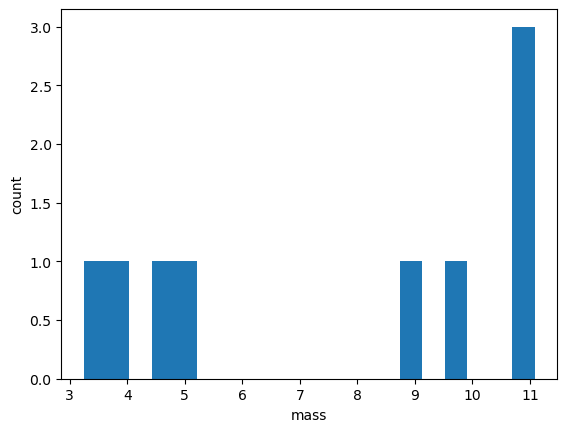

In [130]:

fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count')
     

> 5. Batch process the stack, link particles into trajectories, filter short trajectories

In [6]:
# Version one file
#all_particles = tp.batch(images_0,diameter=5, minmass=150, separation=20, noise_size=1.0, processes=1)
all_particles = tp.batch(images_1, diameter=(5,5), minmass=1, separation=20, noise_size=1.0, processes=1, threshold=None, smoothing_size=None)


Frame 400: 8 features


In [172]:
#all_linked = tp.link(all_particles, search_range=1, memory=1)
all_linked = tp.link(all_particles, search_range=2, memory=1)
#all_linked_filtered = tp.filter_stubs(all_linked, 50)
all_linked_filtered = tp.filter_stubs(all_linked, 15)
all_linked_filtered
particles = all_linked_filtered['particle'].unique()
#particles1 = all_linked['particle'].unique()
particles

Frame 400: 8 trajectories present.


array([  0,   3,   4,   5,   6,  12,  14,  20,  21,  31,  35,  45,  64,
       117, 118, 119, 129, 143, 145, 148, 171, 179, 181, 186, 197, 202,
       206, 217, 223, 224, 227, 232, 233, 234, 237, 239, 241, 246, 252,
       262, 263, 269, 273, 287, 303, 309])

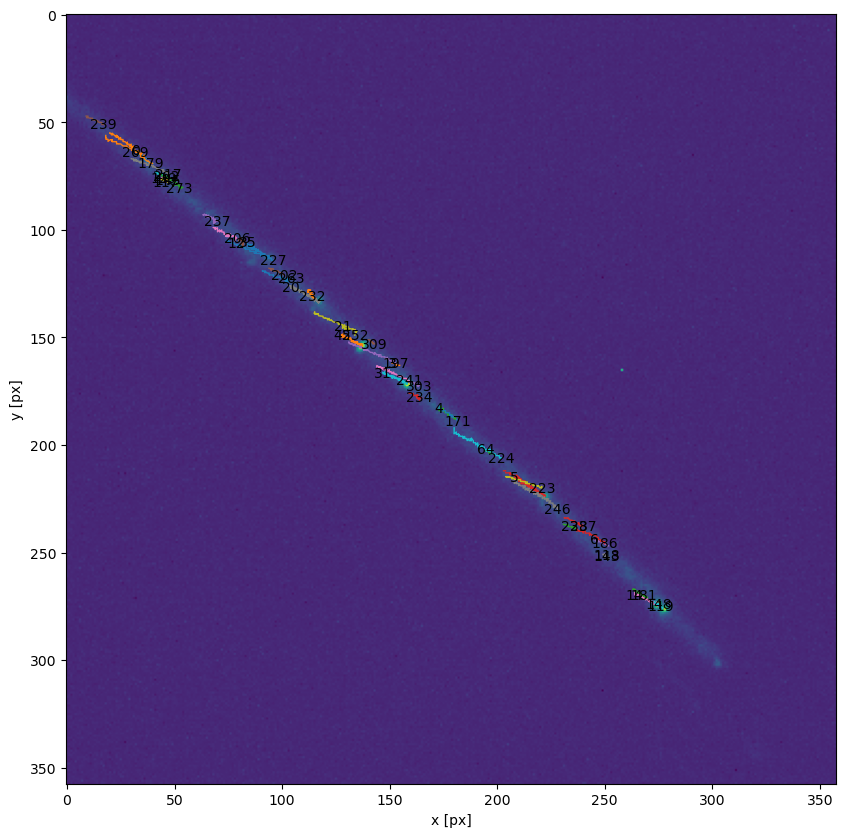

<AxesSubplot:xlabel='x [px]', ylabel='y [px]'>

In [173]:
# Inspect results
fig, ax = plt.subplots(1,1, figsize = (10,10))
plt.imshow(images_0[150])
#plt.ylim(500,200)
tp.plot_traj(all_linked_filtered,label=True)


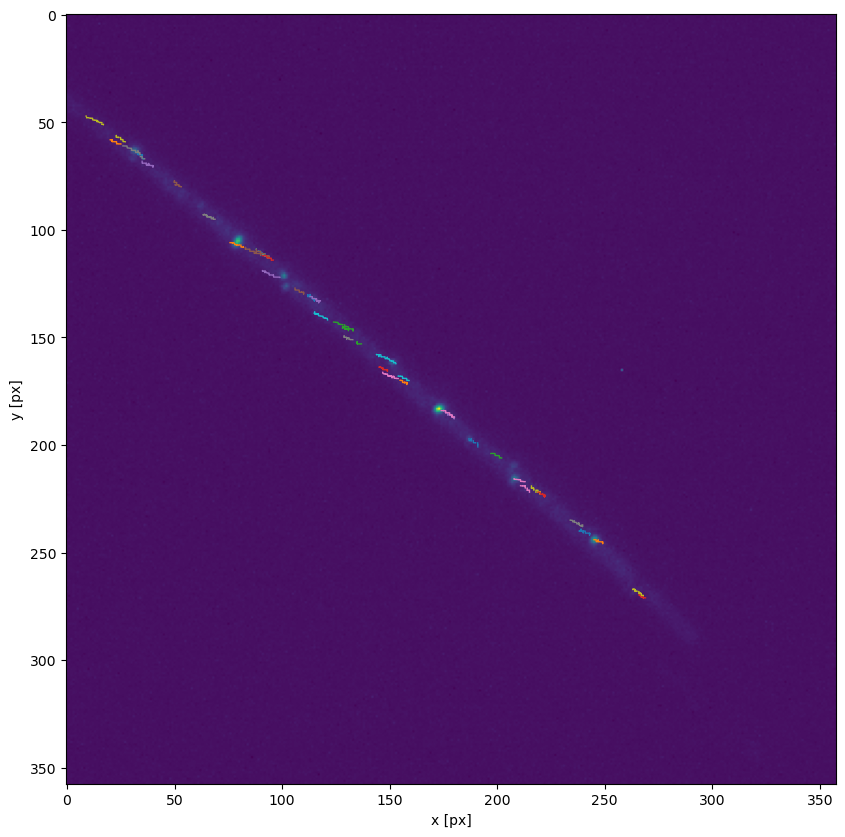

<AxesSubplot:xlabel='x [px]', ylabel='y [px]'>

In [142]:
# there will be some artefacts, these don't really change in x coord
all_linked_filtered1= all_linked_filtered.groupby('particle').filter(lambda group: group['x'].std() >= 0.1)
fig, ax = plt.subplots(1,1, figsize = (10,10))
plt.imshow(images_0[0])
#plt.ylim(500,200)
tp.plot_traj(all_linked_filtered1)

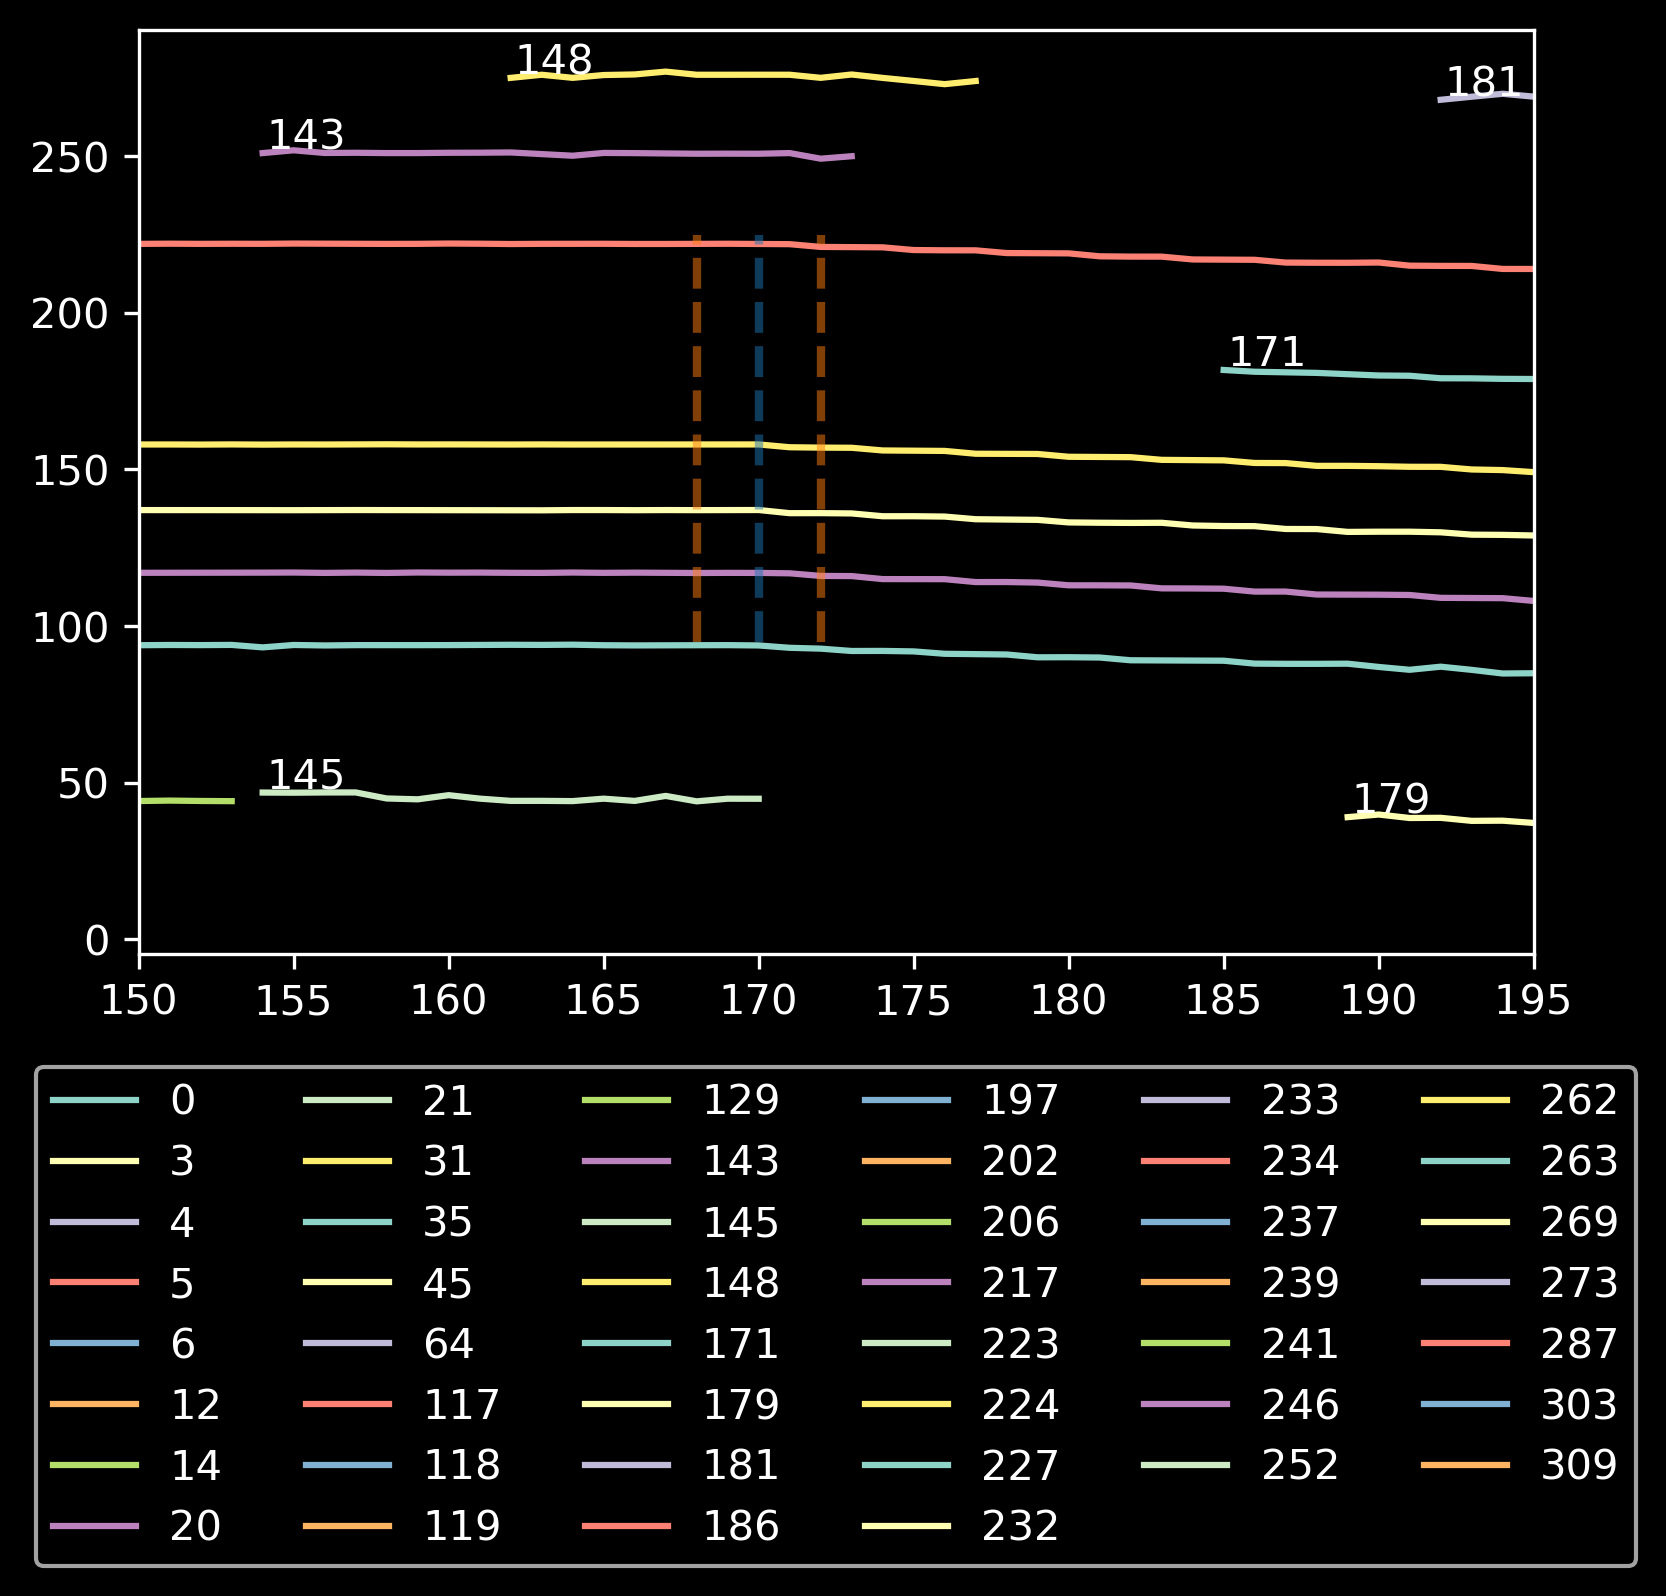

In [175]:
# there will be some artefacts, these don't really change in x coord
#all_linked_filtered= all_linked_filtered.groupby('particle').filter(lambda group: group['x'].std() >= 1)


particles = all_linked_filtered['particle'].unique()

with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,1, figsize = (6,4), dpi=300)
    for particle in particles:
        data_for_particle = all_linked_filtered[(all_linked_filtered['particle'].isin(particles)) 
                                                & (all_linked_filtered['particle']==particle)]
        ax.plot(data_for_particle['frame'].values, data_for_particle['x'].values,'-', label=f'{particle}')
        #ax.plot(data_for_particle['frame'].values, data_for_particle['y'].values,'-', label=f'{particle}')
        #ax.plot(data_for_particle['frame'].values, np.sqrt(data_for_particle['x'].values**2+data_for_particle['y'].values**2),'-', label=f'{particle}')
        ax.annotate(f'{particle}', xy=(data_for_particle['frame'].values[0], data_for_particle['x'].values[0]), xytext=(1, 1),textcoords='offset points')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=6)
    ax.vlines(x=[168, 170, 172], ymin=95, ymax=225, colors=['tab:orange', 'tab:blue'], ls='--', lw=2, alpha=0.5)
    #ax.set_ylim(258,263)
    ax.set_xlim(150,195)
        

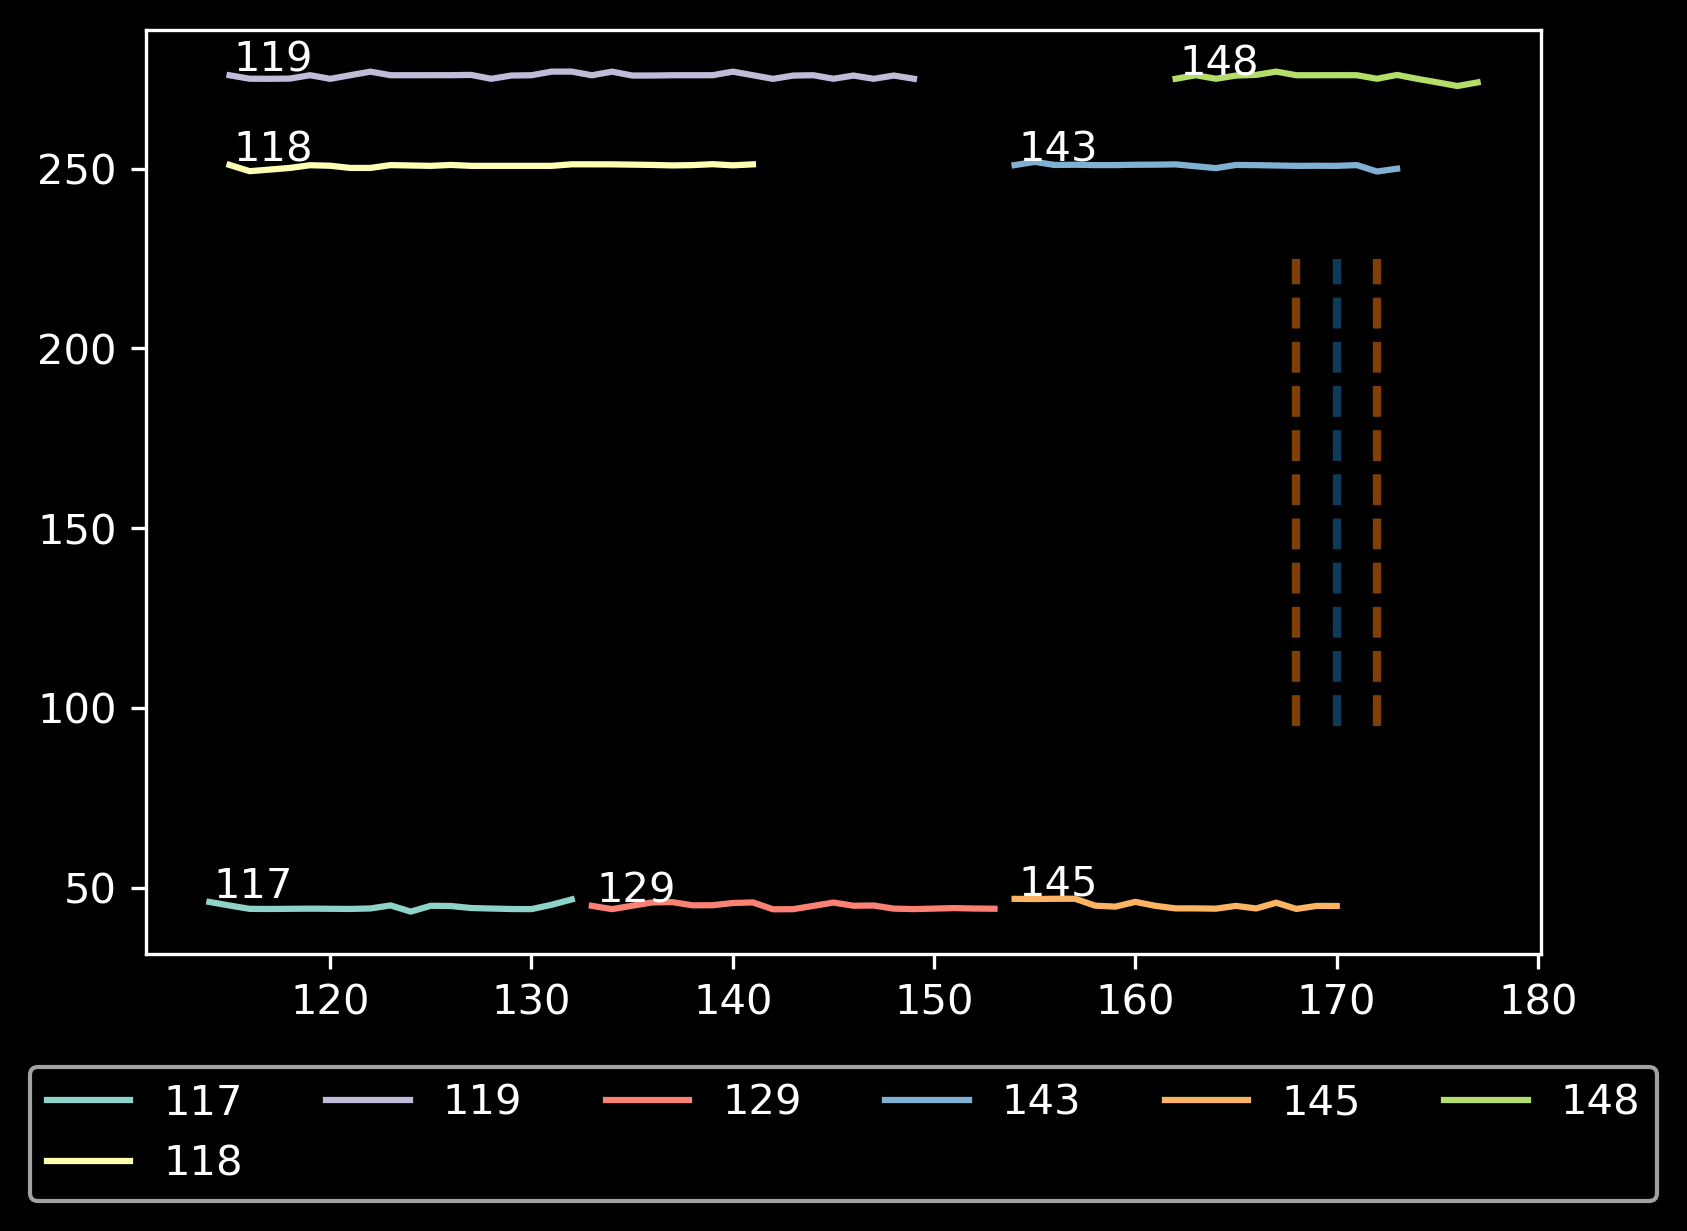

In [165]:
particles = all_linked_filtered['particle'].unique()

with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,1, figsize = (6,4), dpi=300)
    for particle in particles:
        data_for_particle = all_linked_filtered[(all_linked_filtered['particle'].isin(particles)) 
                                                & (all_linked_filtered['particle']==particle)]
        if np.min(data_for_particle['frame'].values)>70 and np.max(data_for_particle['frame'].values)<200:
            ax.plot(data_for_particle['frame'].values, data_for_particle['x'].values,'-', label=f'{particle}')
            ax.annotate(f'{particle}', xy=(data_for_particle['frame'].values[0], data_for_particle['x'].values[0]), xytext=(1, 1),textcoords='offset points')
        #ax.plot(data_for_particle['frame'].values, data_for_particle['y'].values,'-', label=f'{particle}')
        #ax.plot(data_for_particle['frame'].values, np.sqrt(data_for_particle['x'].values**2+data_for_particle['y'].values**2),'-', label=f'{particle}')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=6)
    ax.vlines(x=[168, 170, 172], ymin=95, ymax=225, colors=['tab:orange', 'tab:blue'], ls='--', lw=2, alpha=0.5)
    #ax.set_ylim(258,263)
    #ax.set_xlim(160,180)


In [15]:
all_linked_filtered['experiment'] = filepath_0.stem
all_linked_filtered = all_linked_filtered.reset_index(drop=True)
all_linked_filtered.to_csv(f'tracks/{filepath_0.stem}.csv', index=False)